In [1]:
%matplotlib inline

# Data analysis

In this notebook you will find:
- Necessary imports
- Participant age information
- Number of dyslexic parents
- Function to calculate the average erp per class (risk/no risk)
- Frequency domain features
- Connectivity with stimulus and without 

Note: Make sure you run the data analysis notebook before to have the right paths in the `metadata.csv`!

# Imports

Below are the necessary imports for this notebook. mne_connectivity still needs to be added to the environment. 

In [32]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from math import nan
from numpy import trapz
import researchpy as rp
import scipy.stats as stats

# Make sure that the 5 imports below are all installed using pip install ... 
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity
import pyvista 
import mayavi
import vtk

# To be deleted once eegyolk is working for initializaiton_functions
import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import initialization_functions

import eegyolk
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper

The newest version of mne is necessary to run connectivity plots. If you don't have the latest version, uncomment and run the line below.

In [3]:
# pip install git+https://github.com/mne-tools/mne-python.git

## Load metadata and epochs

In the notebook `data_prep_eeg.ipynb` a csv-file `metadata.csv` is created. It is saved in the same folder as this notebook. The csv contains information about the participants and the corresponding eeg and epoch files. 

In [4]:
metadata = pd.read_csv('metadata.csv', sep = ',')

In [5]:
metadata.head()

,eeg_file,ParticipantID,test,sex,age_months,dyslexic_parent,Group_AccToParents,path_eeg,path_epoch,path_eventmarkers,epoch_file
0,105a,105,a,f,17,f,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,105a_epo.fif
1,107a,107,a,f,16,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,107a_epo.fif
2,106a,106,a,m,19,f,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,106a_epo.fif
3,109a,109,a,m,21,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,109a_epo.fif
4,110a,110,a,m,17,m,At risk,../../volume-ceph/ePodium_projectfolder/dataset,../../volume-ceph/nadine_storage/processed_epochs,../../volume-ceph/ePodium_projectfolder/events,110a_epo.fif


The epochs can be read from the directed paths stored in the metadata. The function below loads all files into a list called `epochs`.

In [6]:
epochs = initialization_functions.read_filtered_data(metadata)

Checking out file: 105a_epo.fif
Checking out file: 107a_epo.fif
Checking out file: 106a_epo.fif
Checking out file: 109a_epo.fif
Checking out file: 110a_epo.fif
Checking out file: 112a_epo.fif
Checking out file: 111a_epo.fif
Checking out file: 114a_epo.fif
Checking out file: 115a_epo.fif
Checking out file: 117a_epo.fif
Checking out file: 116a_epo.fif
Checking out file: 118a_epo.fif
Checking out file: 119a_epo.fif
Checking out file: 123a_epo.fif
Checking out file: 122a_epo.fif
Checking out file: 124a_epo.fif
Checking out file: 127a_epo.fif
Checking out file: 125a_epo.fif
Checking out file: 126a_epo.fif
Checking out file: 130a_epo.fif
Checking out file: 128a_epo.fif
Checking out file: 129a_epo.fif
Checking out file: 131a_epo.fif
Checking out file: 135a_epo.fif
Checking out file: 133a_epo.fif
Checking out file: 137a_epo.fif
Checking out file: 138a_epo.fif
Checking out file: 139a_epo.fif
Checking out file: 141a_epo.fif
Checking out file: 144a_epo.fif
Checking out file: 143a_epo.fif
Checking

## Single participant information

Choose which participant you want to view in the box below. 

In [7]:
index = widgets.IntText(
    step=0.1,
    description='Participant',
    disabled=False
)
widgets.VBox([index])

In [8]:
index = int(index.value)

below files can be dropped, since they do not contain all the events. 

In [9]:
path_eeg = os.path.join(metadata['path_eeg'][index], metadata['eeg_file'][index] + '.bdf')
raw_eeg = mne.io.read_raw_bdf(path_eeg, preload=False)

Extracting EDF parameters from /home/nprins/volume-ceph/ePodium_projectfolder/dataset/105a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


### Visualize raw eeg 

Using matplotlib as 2D backend.
Opening raw-browser...


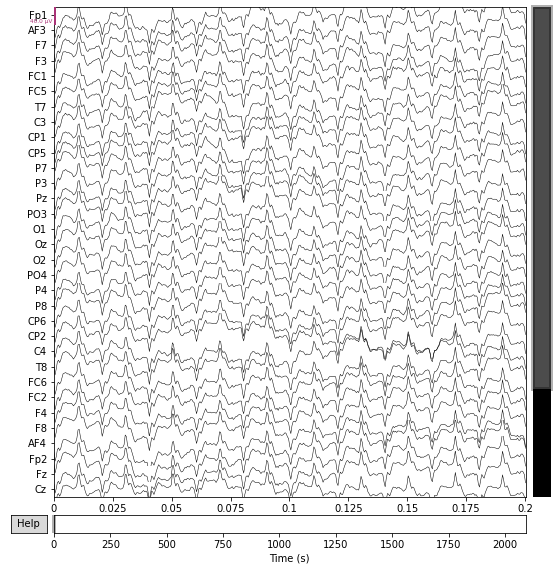

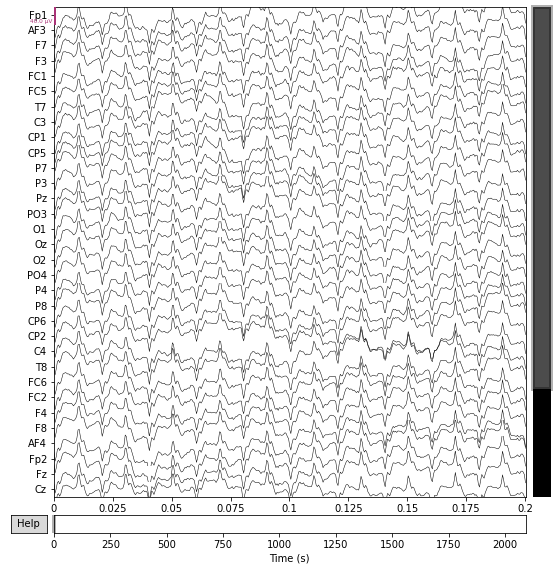

In [10]:
raw_eeg.plot(duration=0.2, n_channels=32)

In [16]:
print(epochs[index].info['ch_names'])

['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']


In [11]:
path_event = os.path.join(metadata['path_eventmarkers'][index], metadata['eeg_file'][index] + '.txt') 
event_markers = np.loadtxt(path_event, dtype=int)
event_markers_simplified = epod_helper.group_events_12(event_markers) # simplify events

/tmp/ipykernel_431534/1301395716.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(event_markers_simplified, event_id = epod_helper.event_dictionary)


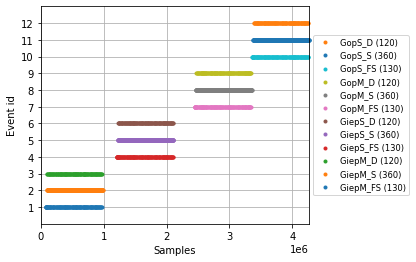

In [12]:
%matplotlib inline 
fig = mne.viz.plot_events(event_markers_simplified, event_id = epod_helper.event_dictionary)

The sensors are placed as the standard montage and are visualized below. 

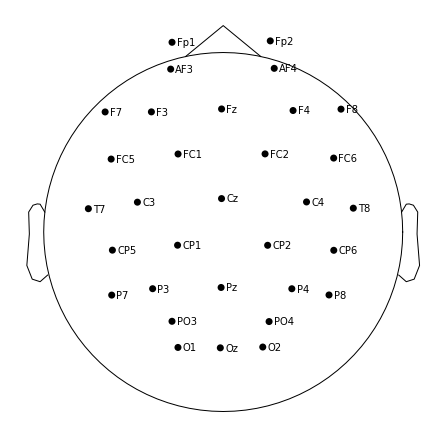

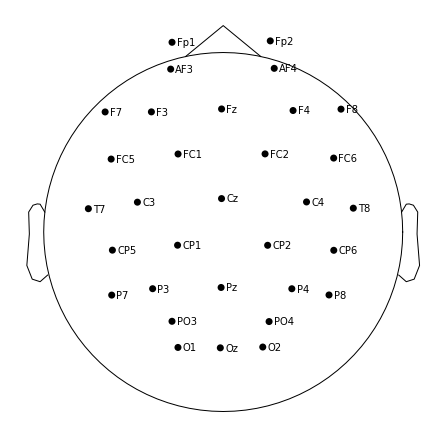

In [13]:
epochs[index].plot_sensors(ch_type='eeg', show_names=True)

### Vizualize epochs and evoked responses

Evoked responses are created by averaging the epochs for a specific event. The function therefore needs as input the created `epochs` and `event_dictionary` containing the different types of events used in the experiment. 

In [14]:
event_dictionary = epod_helper.event_dictionary
evoked = hf.evoked_responses(epochs[index], event_dictionary)

Below each event is plotted for a single subject with the average for each channel. 

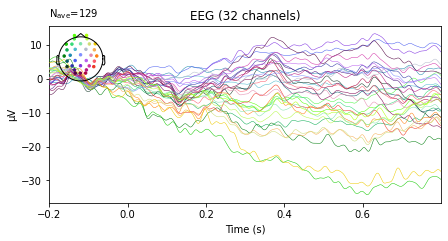

('GiepM_FS', 1)


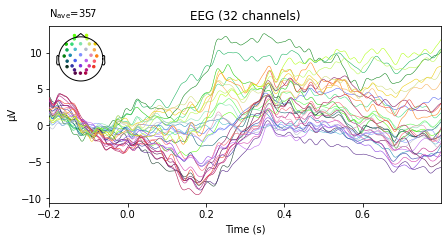

('GiepM_S', 2)


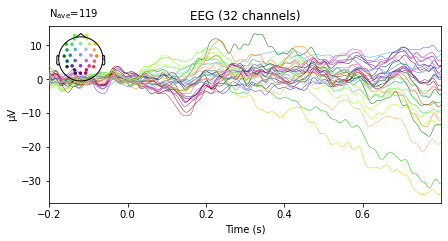

('GiepM_D', 3)


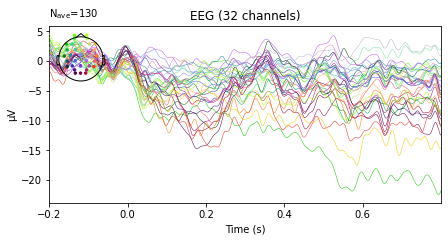

('GiepS_FS', 4)


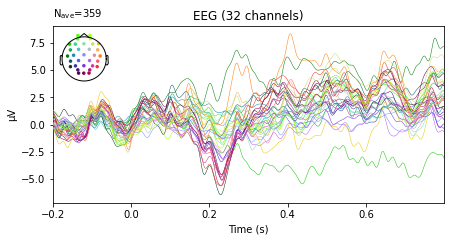

('GiepS_S', 5)


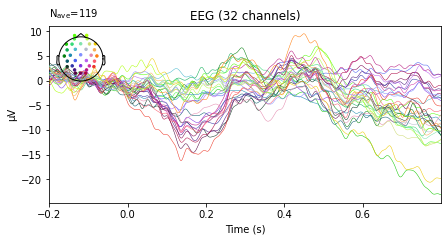

('GiepS_D', 6)


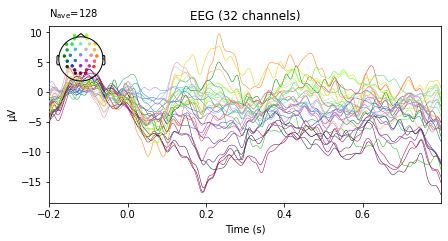

('GopM_FS', 7)


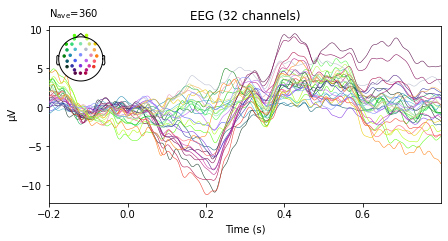

('GopM_S', 8)


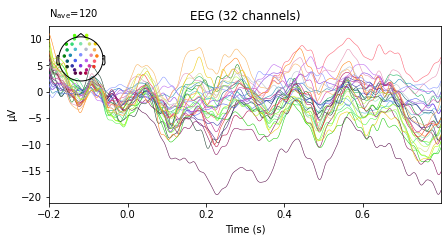

('GopM_D', 9)


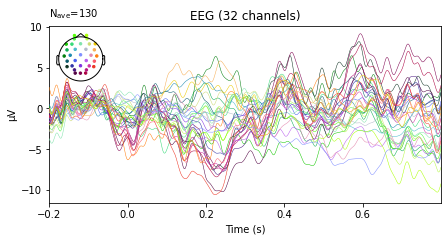

('GopS_FS', 10)


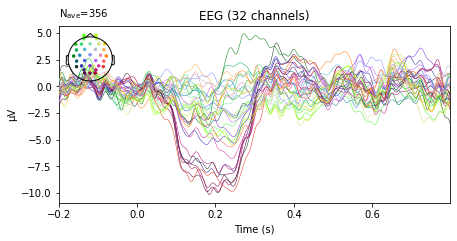

('GopS_S', 11)


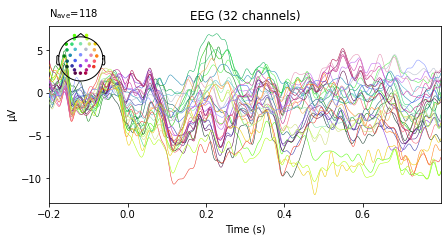

('GopS_D', 12)


In [15]:
for i in range(len(event_dictionary)):
    evoked[i].plot(spatial_colors=True, exclude='bads')
    print(([key for key in epod_helper.event_dictionary.keys()][i], [value for value in epod_helper.event_dictionary.values()][i]))

The grand average is calculated by the average response on all events combined for each channel. 

We will now only look at the standard events, which are events 2, 5, 8 and 11. The first standards were removed, since the participant need some time to adjust to the standard not being 'new' anymore. The deviant events differ from the standard one and are 3, 6, 9 and 12. First, the average per channel for the standard and deviant is calculated and plotted. The second plots shows the mean over all channels between the standard and deviant. 

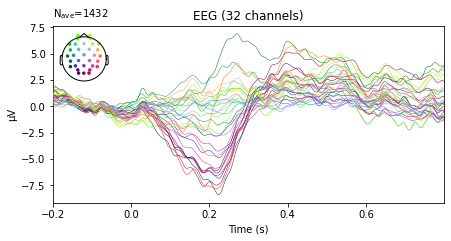

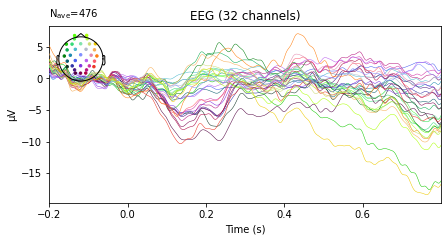

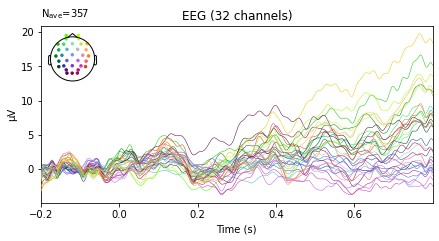

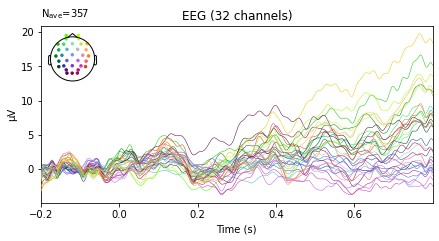

In [14]:
standard = ['GiepM_S','GiepS_S','GopM_S','GopS_S']
deviant = ['GiepM_D','GiepS_D','GopM_D','GopS_D']

std_evoked = epochs[index][standard].average()
dev_evoked = epochs[index][deviant].average()
std_evoked.plot(spatial_colors=True)
dev_evoked.plot(spatial_colors=True)

evoked_diff = mne.combine_evoked([std_evoked, dev_evoked], weights=[1, -1])
evoked_diff.plot(spatial_colors=True)

## All participant information

The value to classify will be whether the participant is at risk for dyslexia or not. The age distribution for both groups is plotted below.

In [15]:
metadata['age_months'].describe()

count    101.000000
mean      17.950495
std        1.458604
min       15.000000
25%       17.000000
50%       18.000000
75%       19.000000
max       21.000000
Name: age_months, dtype: float64

Count of the gender for both groups. 

In [16]:
metadata.groupby('Group_AccToParents')['sex'].value_counts()

Group_AccToParents       sex
At risk                  f      27
                         m      25
At risk (zie opmerking)  f       1
Control                  m      27
                         f      21
Name: sex, dtype: int64

Count of whether the mom or dad is dyslexic or not. 

In [17]:
metadata.groupby('Group_AccToParents')['dyslexic_parent'].value_counts()

Group_AccToParents       dyslexic_parent
At risk                  m                  26
                         f                  21
                         mf                  5
At risk (zie opmerking)  f                   1
Control                  Nee                48
Name: dyslexic_parent, dtype: int64

## ERP per group

This function is able to calculate the average erp for a specific condition. The function needs a dataframe like `metadata.csv` which contains the epoch files and the participants characteristics. It also needs as input the characteristic we are interested in and a single value of this characteristic. For example if we want to look at the average erp for the children who are at risk, the group will be the column (feature) containing the values at risk or control and the value will be 'at risk'. The function also needs the event dictionary in order to average the epochs over multiple participants. 

In [18]:
def data_analysis(dataframe, group, value, event_dictionary):
    epochs = []
    dataframe = dataframe.loc[metadata[group] == value]
    filenames = []
    
    for index, file in dataframe.iterrows():
        #print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False, verbose=False)
        epochs.append(epoch)
        filenames.append(file['epoch_file'])
    
    for event in event_dictionary:
        evokeds = []
        for epoch in epochs:
            evoked = epoch[event].average()
            evokeds.append(evoked)
        
        grand_evoked_events = mne.grand_average(evokeds)
        grand_evoked_events.plot(spatial_colors=True, exclude='bads')
        print(event)       
    
    return 

In [19]:
atrisk = data_analysis(metadata, group='Group_AccToParents', value = 'At risk', event_dictionary = epod_helper.event_dictionary)

In [20]:
control = data_analysis(metadata, group='Group_AccToParents', value = 'Control', event_dictionary = epod_helper.event_dictionary)

Above function calculates the response for all events. Below function calculates the mismatch response for specified events.

In [21]:
def mmr_analysis(dataframe, group, value, standard_events, deviant_events):    
    epochs = []
    dataframe = dataframe.loc[metadata[group] == value]
    filenames = []
    std_tot = []
    dev_tot = []
    mmr = []
    
    # Get epochs of the group
    for index, file in dataframe.iterrows():
        # print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False, verbose=False)
        epochs.append(epoch)
        filenames.append(file['epoch_file'])
    
    # calculate standard and deviant 
    for epoch in epochs:
        std_evoked = epoch[standard_events].average() 
        dev_evoked = epoch[deviant_events].average()
        # append all mismatch for all participants
        std_tot.append(std_evoked)
        dev_tot.append(dev_evoked)
 
    
    # calculate grand average of standard and deviant
    grand_std_evoked = mne.grand_average(std_tot) 
    grand_dev_evoked = mne.grand_average(dev_tot)
    # plot standard and deviant 
    print(f" Group average of{standard_events}")
    grand_std_evoked.plot(spatial_colors=True, exclude='bads')
    print(f" Group average of{deviant_events}")
    grand_dev_evoked.plot(spatial_colors=True, exclude='bads')
    # calculate and plot mmr
    evoked_diff = mne.combine_evoked([grand_std_evoked, grand_dev_evoked], weights=[1, -1]) # mismatch for all channels per participant
    print(f" Mismatch of {standard_events} and {deviant_events}")
    evoked_diff.plot(spatial_colors=True, exclude='bads')
     
    return 

Identifying common channels ...
Identifying common channels ...
 Group average of['GiepM_S', 'GiepS_S', 'GopM_S', 'GopS_S']


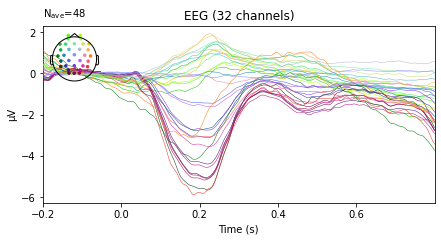

 Group average of['GiepM_D', 'GiepS_D', 'GopM_D', 'GopS_D']


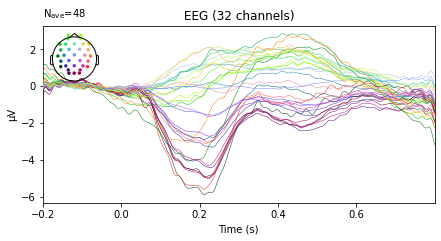

 Mismatch of ['GiepM_S', 'GiepS_S', 'GopM_S', 'GopS_S'] and ['GiepM_D', 'GiepS_D', 'GopM_D', 'GopS_D']


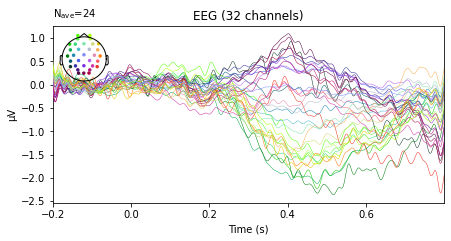

In [22]:
standard_events = ['GiepM_S','GiepS_S','GopM_S','GopS_S'] # standards: 'GiepM_S','GiepS_S','GopM_S','GopS_S'
deviant_events = ['GiepM_D','GiepS_D','GopM_D','GopS_D'] # deviants: 'GiepM_D','GiepS_D','GopM_D','GopS_D'
control_mmr = mmr_analysis(metadata, group='Group_AccToParents', value = 'Control', standard_events=standard_events, deviant_events=deviant_events)

Identifying common channels ...
Identifying common channels ...
 Group average of['GiepM_S', 'GiepS_S', 'GopM_S', 'GopS_S']


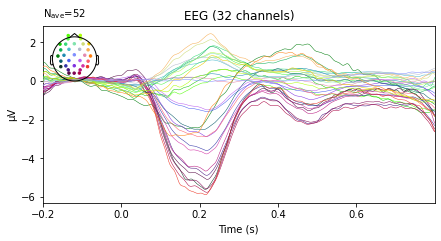

 Group average of['GiepM_D', 'GiepS_D', 'GopM_D', 'GopS_D']


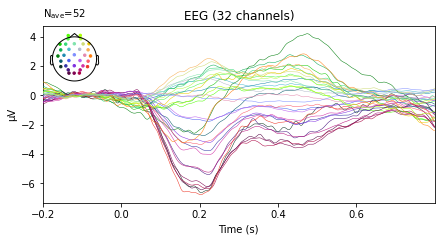

 Mismatch of ['GiepM_S', 'GiepS_S', 'GopM_S', 'GopS_S'] and ['GiepM_D', 'GiepS_D', 'GopM_D', 'GopS_D']


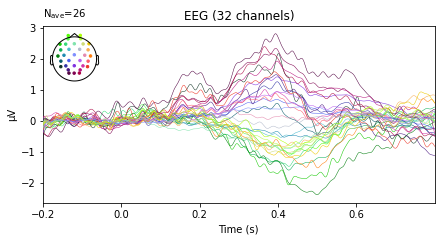

In [23]:
atrisk_mmr = mmr_analysis(metadata, group='Group_AccToParents', value = 'At risk', standard_events=standard_events, deviant_events=deviant_events)

Below function was a sanity check to see whether all participants showed the same characteristics as the overall group response. 

In [24]:
def mmr_pp_analysis(dataframe, group, value, standard_events, deviant_events):    
    epochs = []
    dataframe = dataframe.loc[metadata[group] == value]
    filenames = []
    std_tot = []
    dev_tot = []
    mmr = []
    
    # Get epochs of the group
    for index, file in dataframe.iterrows():
        # print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False, verbose=False)
        epochs.append(epoch)
        filenames.append(file['epoch_file'])
    
    # calculate standard and deviant 
    for epoch in epochs:
        std_evoked = epoch[standard_events].average() 
        dev_evoked = epoch[deviant_events].average()
       
       # plot standard and deviant 
        evoked_diff = mne.combine_evoked([std_evoked, dev_evoked], weights=[1, -1]) # mismatch for all channels per participant
        print(f" Mismatch of {standard_events} and {deviant_events}")
        evoked_diff.plot(spatial_colors=True, exclude='bads')
    
    return

In [25]:
control_pp = mmr_pp_analysis(metadata, group='Group_AccToParents', value = 'Control', standard_events=standard_events, deviant_events=deviant_events)

In [26]:
atrisk_pp = mmr_pp_analysis(metadata, group='Group_AccToParents', value = 'At risk', standard_events=standard_events, deviant_events=deviant_events)

# T-test

The function below tests whether the diffences between the control and at risk group for each channel are significant.

In [27]:
def ttest(dataframe,test, channel, standard_events, deviant_events):    
    atrisk = []
    control = []
    # Get epochs of the group
    for index, file in dataframe.iterrows():
        
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False, verbose=False)
        
        std_evoked = epoch[standard_events].average() 
        dev_evoked = epoch[deviant_events].average()
       
        evoked_diff = mne.combine_evoked([std_evoked, dev_evoked], weights=[1, -1]).get_data(picks=channel) # mismatch for all channels per participant
        
        if test == 'surface':
            area = trapz(evoked_diff) # calculate area 
            if file['Group_AccToParents'] == 'At risk': 
                atrisk.append(area[0])
            else:  
                control.append(area[0])
        else:
            mean = evoked_diff.mean()
            if file['Group_AccToParents'] == 'At risk': 
                atrisk.append(mean)
            else:  
                control.append(mean)

    return stats.ttest_ind(atrisk,control), atrisk, control

Large t value means that the groups are different. Low t value means that the groups are similar. A p-value from a t test is the probability that the results from your sample data occurred by chance. Low p values are better! Make sure to define if you want to run the t-test on the surface below the curve or the mean. 

In [44]:
standard_events = ['GopS_S'] # standards: 'GiepM_S','GiepS_S','GopM_S','GopS_S'
deviant_events = ['GopS_D'] # deviants: 'GiepM_D','GiepS_D','GopM_D','GopS_D'
ch_names = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']
#ch_names = [ 'FC5', 'Pz', 'O1', 'PO4', 'AF4']
test = 'mean'

for channel in ch_names: 
    ch_ttest, atrisk, control = ttest(metadata, test, channel, standard_events, deviant_events)
    print(channel, ch_ttest)
    #plt.hist(atrisk, bins=20, alpha=0.5, label='at risk')
    #plt.hist(control, bins=20, alpha=0.5, label='control')
    #plt.xlabel(test)
    #plt.ylabel('count')
    #plt.title('At risk vs Control ' + channel)
    #plt.legend(loc='upper right')
    #plt.grid(True)
    #plt.show()
    


Fp1 Ttest_indResult(statistic=0.5572080313962516, pvalue=0.5786429258690713)
AF3 Ttest_indResult(statistic=-0.11702761442542652, pvalue=0.9070752567782243)
F7 Ttest_indResult(statistic=0.5578178098710452, pvalue=0.5782280227911899)
F3 Ttest_indResult(statistic=1.1169630248053237, pvalue=0.2667136159391911)
FC1 Ttest_indResult(statistic=0.9473197801399738, pvalue=0.345782461560568)
FC5 Ttest_indResult(statistic=1.446125205366433, pvalue=0.15130060632630715)
T7 Ttest_indResult(statistic=0.5367079426027537, pvalue=0.5926734580683382)
C3 Ttest_indResult(statistic=-0.4236230956992496, pvalue=0.6727596662380089)
CP1 Ttest_indResult(statistic=-0.08677699802325135, pvalue=0.9310240441628197)
CP5 Ttest_indResult(statistic=0.014006121873449115, pvalue=0.9888532840215931)
P7 Ttest_indResult(statistic=0.4914393792537936, pvalue=0.6242035018723426)
P3 Ttest_indResult(statistic=-1.8629943370250002, pvalue=0.0654277185661981)
Pz Ttest_indResult(statistic=0.3409402493843502, pvalue=0.7338710533513396)

## Connectivity 

Computing eeg connectivity

In [39]:
def data_connectivity(dataframe, group, value):
    epochs = []
    dataframe = dataframe.loc[metadata[group] == value]
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    
    epochs_con = mne.concatenate_epochs(epochs)
    
    fmin, fmax = 4., 9.
    sfreq = epochs_con.info['sfreq']  # the sampling frequency
    tmin = 0.0  # exclude the baseline period
    
    con = spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

    # Now, visualize the connectivity in 3D:
    
    return plot_sensors_connectivity(epochs_con.info, con.get_data(output='dense')[:, :, 0]), spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

In [40]:
connectivityplot_atrisk, connections_atrisk = data_connectivity(metadata, group='Group_AccToParents', value = 'At risk')

In [ ]:
connections_atrisk = connections_atrisk.get_data(output='dense')[:, :, 0]
matrix = pd.DataFrame(connections_atrisk)
matrix

In [ ]:
connectivityplot_control, connections_control = data_connectivity(metadata[:5], group='Group_AccToParents', value = 'Control')

In [ ]:
connections_control = connections_control.get_data(output='dense')[:, :, 0]
matrix = pd.DataFrame(connections_control)
matrix